In [1]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
from torch.autograd import Variable
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from PIL import Image
plt.rcParams['figure.figsize'] = 15, 10

# 生成测试数据

In [1]:
# 取出文本框
def get_text_rect(image):
    img = image.copy()
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img,(5,5),0)
    # ret,img = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,2)

    # 去燥点
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    img = cv2.erode(img, element)
    img = cv2.dilate(img, element)

    img = cv2.blur(img, tuple((5, 5)))
    element = cv2.getStructuringElement(cv2.MORPH_RECT, tuple((5, 5)), (-1, -1))
    img = cv2.dilate(img, element, iterations=2)
    plt.imshow(img,'gray')
    plt.show()    
    nimg, contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = []
    # print(contours)
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        if w > 200 and w < 2000:
            cnts.append([y,x,h,w])
    return cnts

# 取出字符文档框
def get_char_rect(image):
    img = image.copy()
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img,(5,5),0)
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,2)
    # 去燥点
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    img = cv2.erode(img, element)
    img = cv2.dilate(img, element)
    
    img = cv2.blur(img, tuple((3, 3)))
    element = cv2.getStructuringElement(cv2.MORPH_RECT, tuple((3, 3)), (-1, -1))
    img = cv2.dilate(img, element, iterations=1)
    
    nimg, contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        if w >= 30:
            cnts.append([y,x,h,w])
    
    
    return cnts
    

In [78]:
# 读取数据
from common.examdetect import EXDetect
clip_path = 'D:\\PROJECT_TW\\git\\data\\example\\image\\clip\\'
qlists = [0,3,4]
path = 'D:\\PROJECT_TW\\examrc\\data\\exam\\mobile_2\\1.jpg'
with  open(path,'rb') as f:
    imgb = f.read()
image_bin = np.frombuffer(imgb, np.uint8)    
exd = EXDetect(id=1, image=image_bin, mobile_type='default')
print(exd.source_imsage.shape)
print(exd.origin_image.shape)
# plt.imshow(exd.center_img,'gray')
# plt.show()
idx = 30

(4608, 2304, 3)
(4258, 2129, 3)


[[1582, 295, 30, 369], [1582, 1240, 28, 371], [1583, 768, 29, 370], [1654, 293, 30, 371], [1654, 1239, 28, 371], [1655, 768, 29, 369], [1726, 292, 30, 371], [1728, 767, 28, 369], [1997, 704, 28, 368], [1998, 291, 28, 371], [2069, 704, 28, 368], [2070, 291, 28, 371], [2140, 703, 29, 368], [2142, 290, 28, 371], [2212, 703, 29, 367], [2214, 289, 29, 372], [2283, 702, 29, 368], [2285, 288, 29, 372], [2354, 701, 29, 368], [2356, 287, 30, 372], [2424, 287, 34, 1381]]
[[1007, 216, 338, 1642], [1345, 215, 416, 1643], [1761, 211, 699, 1643], [2460, 208, 272, 1639], [2732, 208, 350, 1638]]


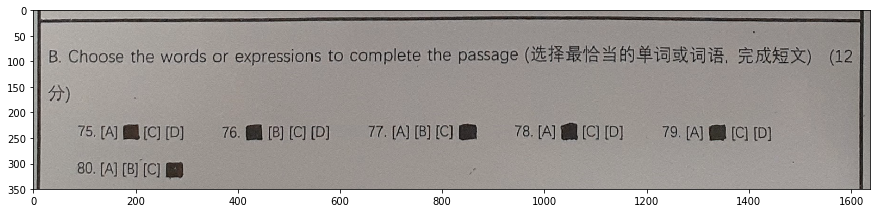

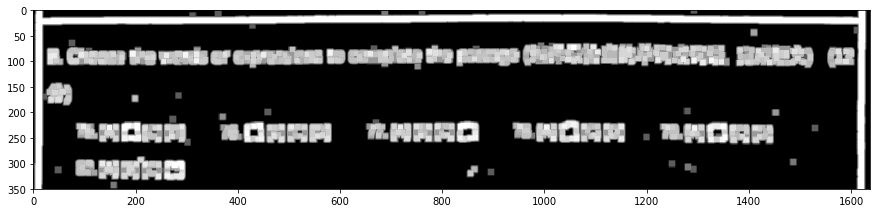

In [43]:
# 分隔试卷，取出包含选择题的项
regions = exd.clip_exam()
rlist = [regions[x] for x in  qlists]
y,x,h,w = rlist[2]
plt.imshow(exd.origin_image[y:y+h,x:x+w],'gray')
plt.show()

# 取出文本框
cnts = get_text_rect(exd.origin_image[y:y+h,x:x+w])

for y1,x1,h1,w1 in cnts:
#     y1,x1,h1,w1 = cnts[1]
    idx = idx + 1
    rimg = exd.origin_image[y+y1:y+y1+h1, x+x1:x+x1+w1]
    cv2.imwrite('{}clip_{}.jpg'.format(clip_path,idx),rimg)

In [87]:
# 从文本框提取字符
import time
clip_path = 'D:\\PROJECT_TW\\git\\data\\example\\image\\clip\\'
clip_save_path = 'D:\\PROJECT_TW\\git\\data\\example\\image\\char\\'
clip_file_name = '23_A-CD'
b_number = 0
n_number = 0

files = os.listdir(clip_path)
start_time = time.time()
for file in files:
    clip_file_name = file.split('.')[0]
    print(clip_file_name)
    image = cv2.imread('{}{}.jpg'.format(clip_path,clip_file_name),cv2.IMREAD_COLOR)
    print(image.shape)
    cnts = get_char_rect(image)
    cnts_array = np.array(cnts)
    cnts_inx = np.lexsort([cnts_array[:,1]])
    cnts_array = cnts_array[cnts_inx]
    cnts = cnts_array.tolist()
    binx = [idx for idx,x in enumerate(clip_file_name.split('_')[-1]) if x =='-']

    for i, (y,x,h,w) in enumerate(cnts[1:]):
        crop_img = image[y:y+h,x:x+w]
        if i in binx:
            cv2.imwrite('{}1_{}.jpg'.format(clip_save_path,b_number),crop_img)
            b_number = b_number + 1
        else:
            cv2.imwrite('{}0_{}.jpg'.format(clip_save_path,n_number),crop_img)
            n_number = n_number + 1

print(time.time() - start_time)
    
        

0_ABCD
(49, 221, 3)
10_ABC-
(43, 222, 3)
11_ABC-
(42, 220, 3)
12_A-CD
(48, 221, 3)
13_A-CD
(61, 221, 3)
18_ABC-
(50, 218, 3)
19_A-CD
(45, 225, 3)
1_A-CDE
(43, 262, 3)
20_-BCD
(45, 222, 3)
21_A-CD
(47, 223, 3)
22_ABC-
(48, 224, 3)
23_A-CD
(60, 227, 3)
3_-BCDE
(45, 260, 3)
4_A-CDE
(52, 263, 3)
5_ABCD-
(42, 264, 3)
6_A-CDE
(43, 263, 3)
7_-BCDE
(44, 262, 3)
9_A-CD
(45, 220, 3)
0.6790425777435303


# 数据准备

In [3]:
# https://github.com/pytorch/vision/issues/81

# 将图片数据写入到LMDB数据库存中

import lmdb
import glob
# 创建数据库
# import lmdb  # install lmdb by "pip install lmdb"
# env = lmdb.open('./data/lmdb', map_size=511627776)
# env = lmdb.open('./data/lmdb', map_size=511627776)
# from genLineText import GenTextImage
def checkImageIsValid(imageBin):
    if imageBin is None:
        return False
    
    imageBuf = np.frombuffer(imageBin, dtype=np.uint8)
    img = cv2.imdecode(imageBuf, cv2.IMREAD_COLOR)
    if img is None:
        return False
    imgH, imgW = img.shape[0], img.shape[1]
    if imgH * imgW == 0:
        return False
    return True

def writeCache(env, cache):
    with env.begin(write=True) as txn:
        for k, v in cache.items():
            txn.put(k.encode(), v)
            
def createDataset(outputPath, imagePathList, labelList, lexiconList=None, checkValid=True):
    """
    Create LMDB dataset for CRNN training.
    ARGS:
        outputPath    : LMDB output path
        imagePathList : list of image path
        labelList     : list of corresponding groundtruth texts
        lexiconList   : (optional) list of lexicon lists
        checkValid    : if true, check the validity of every image
    """
    # print (len(imagePathList) , len(labelList))
    assert (len(imagePathList) == len(labelList))
    nSamples = len(imagePathList)
    
    env = lmdb.open(outputPath, map_size=511627776)

    cache = {}
    cnt = 1
    for i in range(nSamples):
        imagePath = imagePathList[i]
        label = labelList[i]
        if not os.path.exists(imagePath):
            print('%s does not exist' % imagePath)
            continue
        with open(imagePath, 'rb') as f:
            imageBin = f.read()
        
        if checkValid:
            if not checkImageIsValid(imageBin):
                print('%s is not a valid image' % imagePath)
                continue

        imageKey = 'image-%09d' % cnt
        labelKey = 'label-%09d' % cnt
        cache[imageKey] = imageBin
        cache[labelKey] = label.encode()
        if lexiconList:
            lexiconKey = 'lexicon-%09d' % cnt
            cache[lexiconKey] = ' '.join(lexiconList[i]).encode()
        if cnt % 1000 == 0:
            writeCache(env, cache)
            cache = {}
            print('Written %d / %d' % (cnt, nSamples))
        cnt += 1
    nSamples = cnt - 1
    cache['num-samples'] = str(nSamples).encode()
    writeCache(env, cache)
    print('Created dataset with %d samples' % nSamples)


def read_text(path):
    with open(path) as f:
        text = f.read()
    text = text.strip()

    return text

# outputPath = './data/lmdb/train'   # 训练数据
outputPath = 'D:\\PROJECT_TW\\git\\data\\example\\lmdb'   # 测试数据
path = 'D:\\PROJECT_TW\\git\\data\\example\\image\\char\\*.jpg'
imagePathList = glob.glob(path)
imgLabelLists = []
for p in imagePathList:
    try:
        label = p.split('\\')[-1].split('_')[0]
        imgLabelLists.append((p,label))
    except:
        continue

imgLabelList = sorted(imgLabelLists, key=lambda x: len(x[1]))
imgPaths = [p[0] for p in imgLabelList]
txtLists = [p[1] for p in imgLabelList]
createDataset(outputPath, imgPaths, txtLists, lexiconList=None, checkValid=True)

Created dataset with 74 samples


In [2]:
# 加载数据
# 注意 dataset.alignCollate 将图片转成了灰度图，后期看怎么修改一下。
# collate_fn，是用来处理不同情况下的输入dataset的封装，一般采用默认即可，除非你自定义的数据读取输出非常少见
import common.dataset as dataset
path = 'D:\\PROJECT_TW\\git\\data\\example\\lmdb'
train_dataset = dataset.lmdbDataset(root=path, transform=dataset.resizeNormalize((32,32)))
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    sampler=None
#     collate_fn=dataset.alignCollate(imgH=32, imgW=32, keep_ratio=False)
)

# dataset 方法resizeNormalize 中用了transforms.ToTensor 会将数据做归一化处理，在正式用的时候也需要将数据调用该方法做归一化处理

# 可参看 https://blog.csdn.net/victoriaw/article/details/72822005 数据预处理torchvision.transforms 


In [3]:
for idx,v in enumerate(train_loader):
#     print(idx,v)
#     print(v)
    pass
# print(v)
print(idx)
# print(np.array(v[0]).shape)

36


# 数据模型

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_1 = nn.Sequential(         # input shape (1, 32, 32)
            nn.Conv2d(
                in_channels=3,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 16, 16)
        )        
        
        self.conv_2 = nn.Sequential(         # input shape (16, 16, 16)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 16, 16)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 8, 8)
        )        
        
        self.out = nn.Linear(32 * 8 * 8, 2)   # fully connected layer, output 2 classes
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 8 * 8)
        output = self.out(x)
        return output       # return x for visualization    
        

# 训练

In [7]:
# https://blog.csdn.net/tianweidadada/article/details/82630735   用 pytorch 进行分类（二分类，多分类）
net = CNN()
opitmizer = torch.optim.SGD(net.parameters(),lr=0.01)
loss_fun = nn.MSELoss() 
epoches = 1000


for i in range(epoches):
    for step, values in enumerate(train_loader):
        images = values[0]
        # 二分类，target 在做损失的时候需要（0，1），（1，0）这样的格式
        target = [ [1-int(x),int(x) ] for x in values[1]]
        target =  Variable(torch.FloatTensor(target)) #变成 1*2的 tensor
        preds = F.softmax(net(images),dim=1)
        loss = loss_fun(preds,target)
        opitmizer.zero_grad()
        loss.backward()
        opitmizer.step()
    if i%100 == 0:
        print('loss --> {:.4f}'.format(loss))


loss --> 0.0226
loss --> 0.0000
loss --> 0.0000
loss --> 0.0000
loss --> 0.0000
loss --> 0.0000
loss --> 0.0000
loss --> 0.0000
loss --> 0.0000
loss --> 0.0000


# 验证

In [20]:
import torchvision.transforms as transforms 
import time
path = 'D:\\PROJECT_TW\\git\\data\\example\\image\\char\\1_15.jpg'
image = cv2.imread(path,cv2.IMREAD_COLOR)    
if image.shape[0] != 32 or image.shape[1] != 32:
    image = cv2.resize(image,(32,32))
# aa[np.newaxis,:].shape, newaxis增加维度
# np.r_[bb,bb].shape 添加行数据
# image = image[np.newaxis,:]
print(image.shape)

start_time = time.time()
for _ in range(1):

    imdata = transforms.ToTensor()(image)
    imdata = imdata.unsqueeze(0)
#     print(imdata.size())
    preds = net(imdata)
    preds = F.softmax(preds,dim=1)
    print(preds)
    
print('time --> {}'.format((time.time()-start_time)))


(32, 32, 3)
tensor([[ 0.0027,  0.9973]])
time --> 0.06861186027526855
